In [37]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbrn

fontsize = 13
custom = {"axes.edgecolor": "black","grid.linestyle": "dashed", "grid.color": "gray"}
sbrn.set_context('paper')
sbrn.set_style("whitegrid", rc = custom)

# Open the JSON file for reading
with open('./3DSlice_Data/1nodeSERIAL.json', 'r') as file:
    data = json.load(file)

df = pd.json_normalize(data['benchmarks'])
df['repetition_index'] = df['repetition_index'].fillna(0)

In [38]:
# Customize the x-axis ticks to show byte values more clearly
from matplotlib.ticker import FuncFormatter
def byte_formatter(x, pos):
    if x == 0:
        return '0 B'
    elif x < 1024:
        return f'{int(x)} B'
    elif x < 1024**2:
        return f'{int(x / 1024)} KB'
    else:
        return f'{int(x / 1024**2)} MB'
# Customize the y-axis ticks to show time values more clearly
def time_formatter(y, pos):
    if y < 1:
        return f'{y * 1000:.1f} ns'
    elif y < 1000:
        return f'{y:.1f} us'
    elif y < 1000000:
        return f'{y / 1000:.1f} ms'
    else:
        return f'{y / 1000000:.1f} s'

In [39]:
extracted_data = []
# Loop through the benchmarks in the JSON data
for i,benchmark in df.iterrows() :
    # Extract the relevant information
    name = benchmark['name']
    real_time = benchmark['real_time']
    bytes = benchmark['bytes']
    # Determine the packing type from the name
    if 'deepcopy' in name:
        pack_type = 'DeepCopy'
    elif 'datatype' in name:
        pack_type = 'MPIDatatype'
    else:
        continue  # Skip if none
    # Determine the slice type from the name
    if 'noncontig2D' in name:
        slice_type = 'Noncontig2D'
    elif 'noncontig' in name:
        slice_type = 'Noncontig'
    elif 'contig' in name:
        slice_type = 'Contig'
    
    if 'mean' in name:
        extracted_data.append({'pack_type': pack_type, 'slice_type': slice_type, 'real_time': real_time, 'bytes': bytes})
edf = pd.DataFrame(extracted_data)
# Create a combined column for comm_type and func_type
edf['combined_type'] = edf['pack_type'] + ' ' + edf['slice_type']

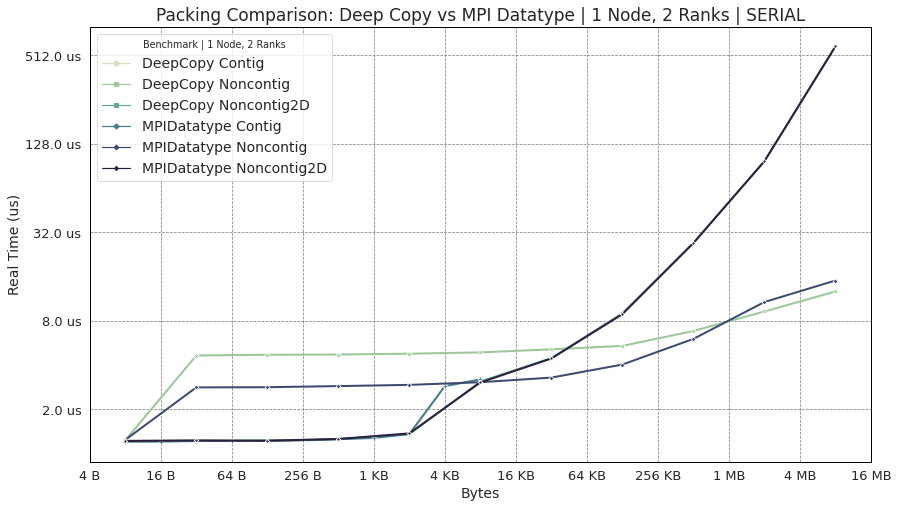

In [40]:
# Plot 0: Compare All, CPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Deep Copy vs MPI Datatype | 1 Node, 2 Ranks | SERIAL', fontsize=fontsize + 4)

# Create a pastel rainbow color palette
palette = sbrn.cubehelix_palette(start=0.5, rot=-0.75, light=0.85, dark=0.15, n_colors=len(edf['combined_type'].unique()))

# Plot with custom palette and solid lines
sbrn.lineplot(data=edf, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, palette=palette, dashes=False)

plt.legend(title='Benchmark | 1 Node, 2 Ranks', fontsize=fontsize+1)
plt.xlabel('Bytes', fontsize=fontsize+1)
plt.ylabel('Real Time (us)', fontsize=fontsize+1)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.75)
plt.savefig("./3DSlice_Data/3dslice_1nodeSERIAL.png", dpi=300)
plt.show()

In [41]:
# Define subsets to plot separately
subset1 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Contig') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Contig')]

subset2 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Noncontig') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Noncontig')]

subset3 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Noncontig2D') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Noncontig2D')]

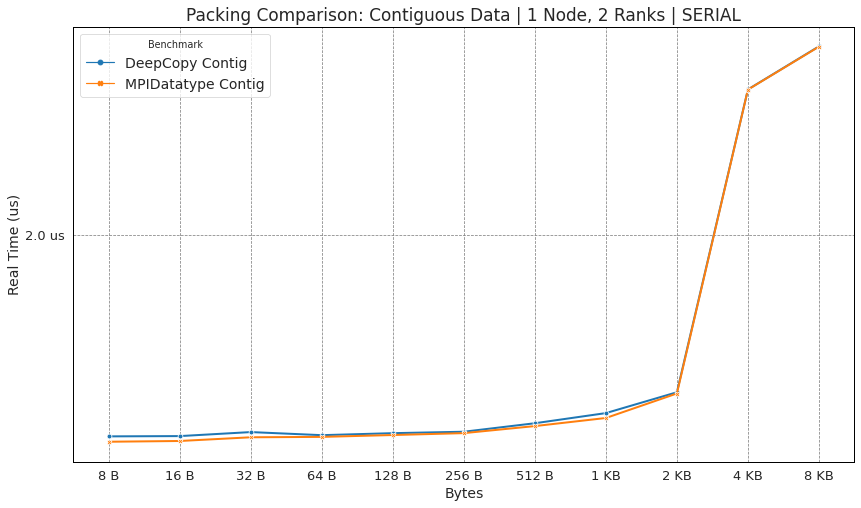

In [42]:
# Plot 1: Contig, CPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Contiguous Data | 1 Node, 2 Ranks | SERIAL', fontsize=fontsize + 4)
# Create a pastel rainbow color palette with two colors
palette = sbrn.cubehelix_palette(start=0.5, rot=-0.75, light=0.85, dark=0.15, n_colors=2)

sbrn.lineplot(data=subset1, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.75)
plt.savefig("./3DSlice_Data/3dslicecontig_1nodeSERIAL.png", dpi=300)
plt.show()

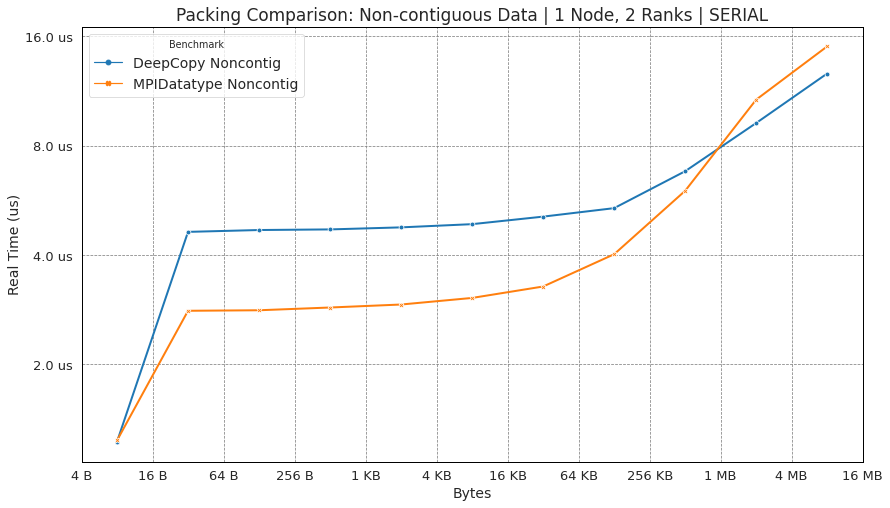

In [43]:
# Plot 2: Noncontig
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-contiguous Data | 1 Node, 2 Ranks | SERIAL', fontsize=fontsize + 4)
sbrn.lineplot(data=subset2, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.75)
plt.savefig("./3DSlice_Data/3dslicenoncontig_1nodeSERIAL.png", dpi=300)
plt.show()

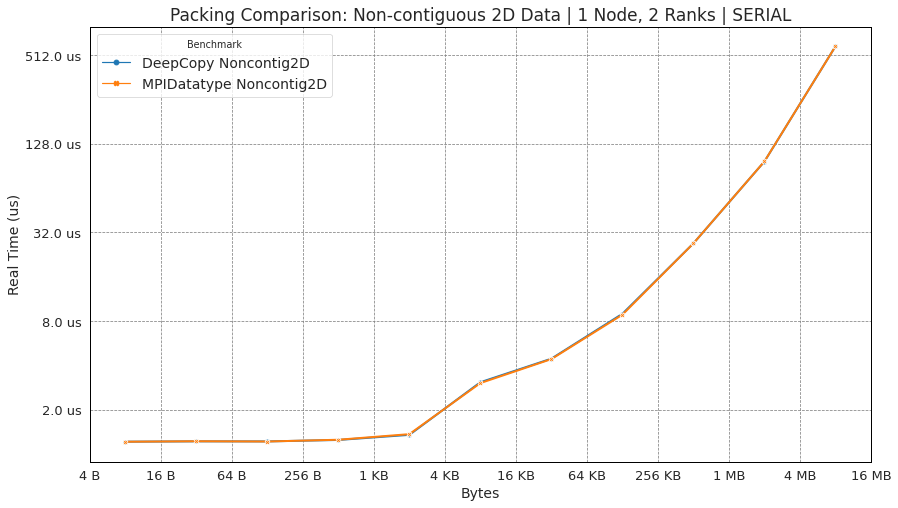

In [44]:
# Plot 3: Noncontig2D
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-contiguous 2D Data | 1 Node, 2 Ranks | SERIAL', fontsize=fontsize + 4)
sbrn.lineplot(data=subset3, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.75)
plt.savefig("./3DSlice_Data/3dslicenoncontig2D_1nodeSERIAL.png", dpi=300)
plt.show()

In [45]:
# Open the JSON file for reading
with open('./3DSlice_Data/2nodesSERIAL.json', 'r') as file:
    data = json.load(file)

df = pd.json_normalize(data['benchmarks'])
df['repetition_index'] = df['repetition_index'].fillna(0)

In [46]:
extracted_data = []
# Loop through the benchmarks in the JSON data
for i,benchmark in df.iterrows() :
    # Extract the relevant information
    name = benchmark['name']
    real_time = benchmark['real_time']
    bytes = benchmark['bytes']
    # Determine the packing type from the name
    if 'deepcopy' in name:
        pack_type = 'DeepCopy'
    elif 'datatype' in name:
        pack_type = 'MPIDatatype'
    else:
        continue  # Skip if none
    # Determine the slice type from the name
    if 'noncontig2D' in name:
        slice_type = 'Noncontig2D'
    elif 'noncontig' in name:
        slice_type = 'Noncontig'
    elif 'contig' in name:
        slice_type = 'Contig'
    if 'mean' in name:
        extracted_data.append({'pack_type': pack_type, 'slice_type': slice_type, 'real_time': real_time, 'bytes': bytes})
edf = pd.DataFrame(extracted_data)
# Create a combined column for comm_type and func_type
edf['combined_type'] = edf['pack_type'] + ' ' + edf['slice_type']

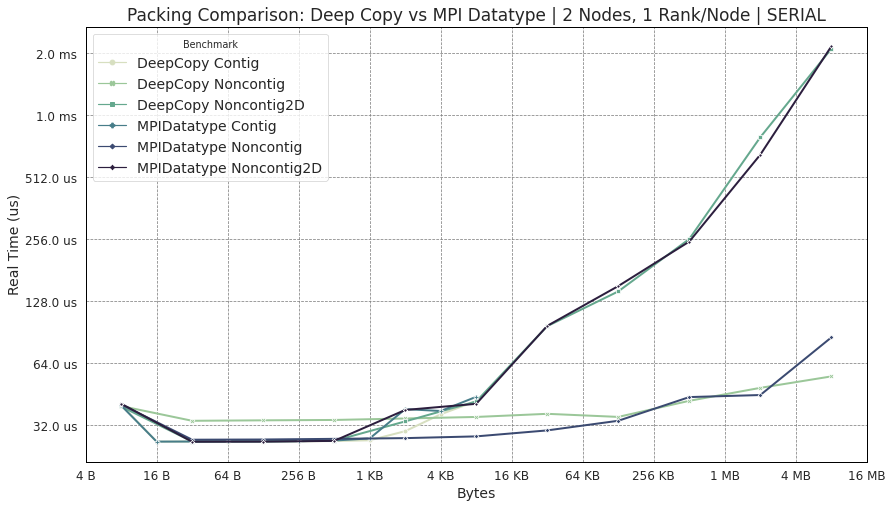

In [47]:
# Plot 4: Compare All, 2 Nodes
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Deep Copy vs MPI Datatype | 2 Nodes, 1 Rank/Node | SERIAL', fontsize=fontsize + 4)
# Create a pastel rainbow color palette
palette = sbrn.cubehelix_palette(start=0.5, rot=-0.75, light=0.85, dark=0.15, n_colors=len(edf['combined_type'].unique()))

sbrn.lineplot(data=edf, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, palette=palette, dashes=False)

plt.legend(title='Benchmark', fontsize=fontsize+1)
plt.xlabel('Bytes', fontsize=fontsize+1)
plt.ylabel('Real Time (us)', fontsize=fontsize+1)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.75)
plt.savefig("./3DSlice_Data/3dslice_2nodesSERIAL.png", dpi=300)
plt.show()

In [48]:
# Define subsets to plot separately
subset1 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Contig') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Contig')]

subset2 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Noncontig') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Noncontig')]

subset3 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Noncontig2D') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Noncontig2D')]

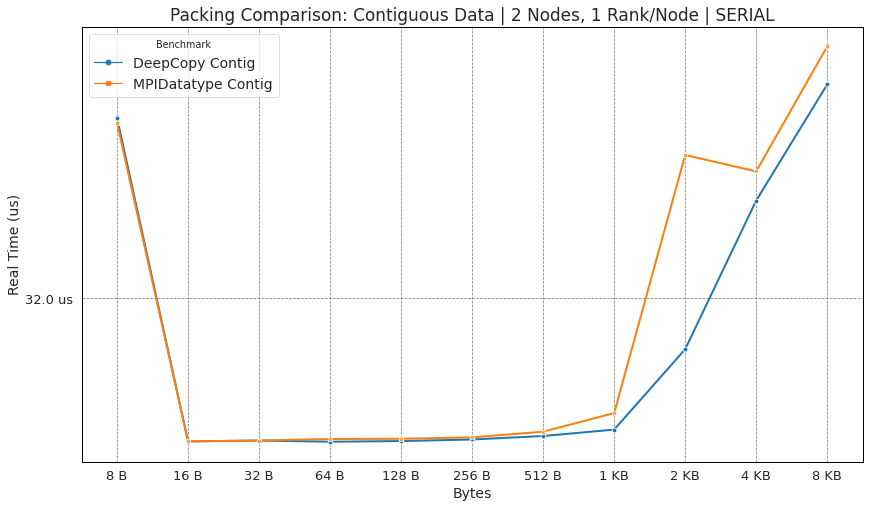

In [49]:
# Plot 5: Contig, 2 Nodes, 1 Rank per Node
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Contiguous Data | 2 Nodes, 1 Rank/Node | SERIAL', fontsize=fontsize + 4)
sbrn.lineplot(data=subset1, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.75)
plt.savefig("./3DSlice_Data/3dslicecontig_2nodesSERIAL.png", dpi=300)
plt.show()

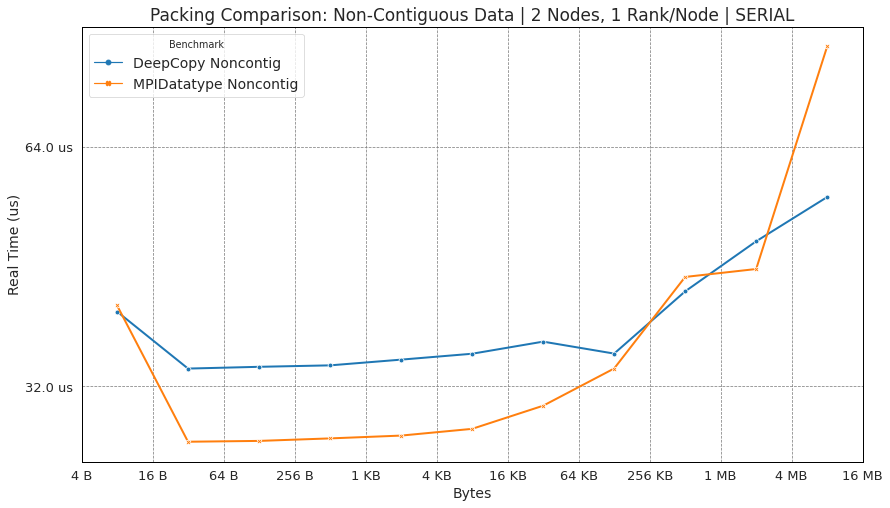

In [50]:
# Plot 6: Noncontig, 2 Nodes, 1 Rank per Node
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-Contiguous Data | 2 Nodes, 1 Rank/Node | SERIAL', fontsize=fontsize + 4)
sbrn.lineplot(data=subset2, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.75)
plt.savefig("./3DSlice_Data/3dslicenoncontig_2nodesSERIAL.png", dpi=300)
plt.show()

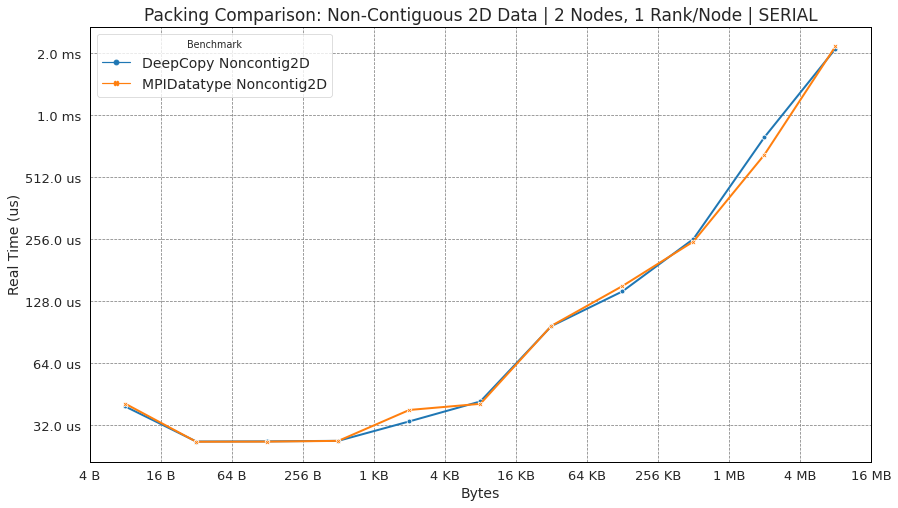

In [51]:
# Plot 6: Noncontig2D, 2 Nodes, 1 Rank per Node
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-Contiguous 2D Data | 2 Nodes, 1 Rank/Node | SERIAL', fontsize=fontsize + 4)
sbrn.lineplot(data=subset3, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.75)
plt.savefig("./3DSlice_Data/3dslicenoncontig2D_2nodesSERIAL.png", dpi=300)
plt.show()

In [52]:
# CUDA ENABLED RUNS
# Open the JSON file for reading
with open('./3DSlice_Data/2nodesCUDA.json', 'r') as file:
    data = json.load(file)

df = pd.json_normalize(data['benchmarks'])
df['repetition_index'] = df['repetition_index'].fillna(0)

In [53]:
extracted_data = []
# Loop through the benchmarks in the JSON data
for i,benchmark in df.iterrows() :
    # Extract the relevant information
    name = benchmark['name']
    real_time = benchmark['real_time']
    bytes = benchmark['bytes']
    # Determine the packing type from the name
    if 'deepcopy' in name:
        pack_type = 'DeepCopy'
    elif 'datatype' in name:
        pack_type = 'MPIDatatype'
    else:
        continue  # Skip if none
    # Determine the slice type from the name
    if 'noncontig2D' in name:
        slice_type = 'Noncontig2D'
    elif 'noncontig' in name:
        slice_type = 'Noncontig'
    elif 'contig' in name:
        slice_type = 'Contig'
    if 'mean' in name:
        extracted_data.append({'pack_type': pack_type, 'slice_type': slice_type, 'real_time': real_time, 'bytes': bytes})
edf = pd.DataFrame(extracted_data)
# Create a combined column for comm_type and func_type
edf['combined_type'] = edf['pack_type'] + ' ' + edf['slice_type']

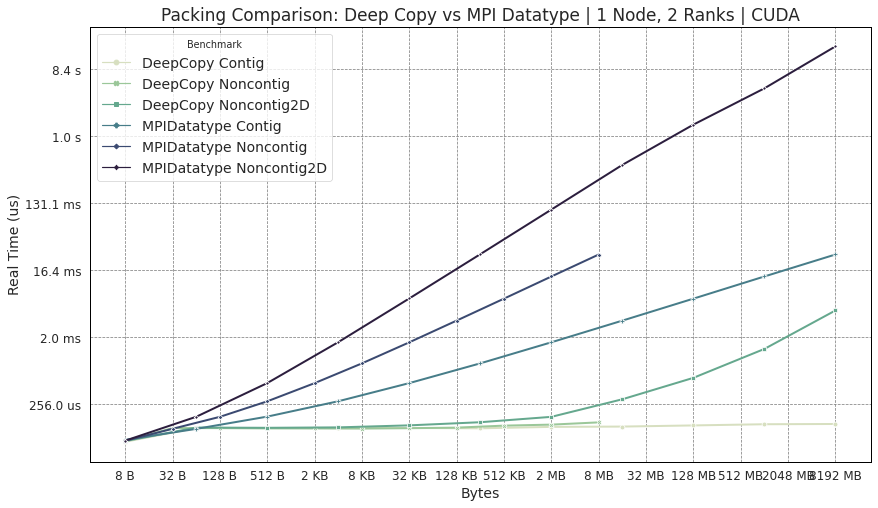

In [54]:
# Plot 7: Compare All, 1 Node, CUDA
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Deep Copy vs MPI Datatype | 1 Node, 2 Ranks | CUDA', fontsize=fontsize + 4)
# Create a pastel rainbow color palette
palette = sbrn.cubehelix_palette(start=0.5, rot=-0.75, light=0.85, dark=0.15, n_colors=len(edf['combined_type'].unique()))

sbrn.lineplot(data=edf, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, palette=palette, dashes=False)

plt.legend(title='Benchmark', fontsize=fontsize+1)
plt.xlabel('Bytes', fontsize=fontsize+1)
plt.ylabel('Real Time (us)', fontsize=fontsize+1)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.75)
plt.savefig("./3DSlice_Data/3dslice_1nodeCUDA.png", dpi=300)
plt.show()

In [55]:
# Define subsets to plot separately
subset1 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Contig') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Contig')]

subset2 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Noncontig') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Noncontig')]

subset3 = edf[(edf['pack_type'] == 'DeepCopy') & (edf['slice_type'] == 'Noncontig2D') | 
              (edf['pack_type'] == 'MPIDatatype') & (edf['slice_type'] == 'Noncontig2D')]

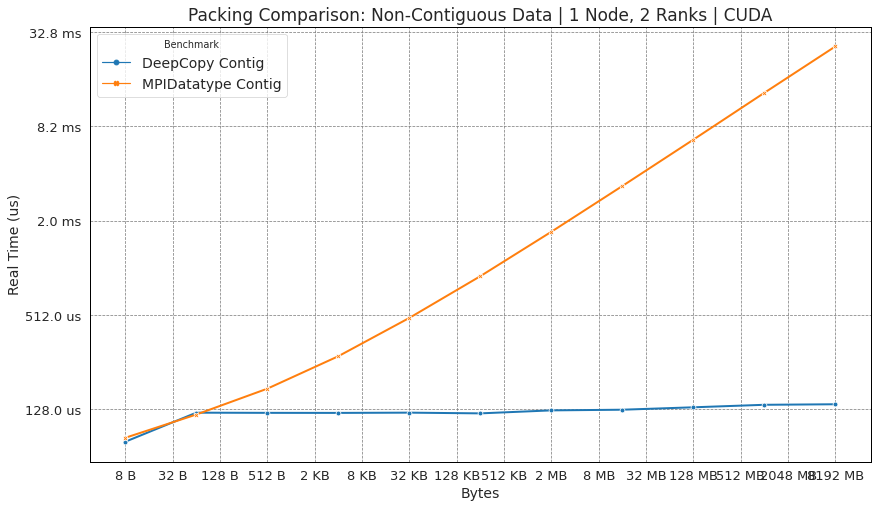

In [56]:
# Plot 8: Contig, 1 Node, GPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-Contiguous Data | 1 Node, 2 Ranks | CUDA', fontsize=fontsize + 4)
sbrn.lineplot(data=subset1, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.75)
plt.savefig("./3DSlice_Data/3dslicecontig_1nodeCUDA.png", dpi=300)
plt.show()

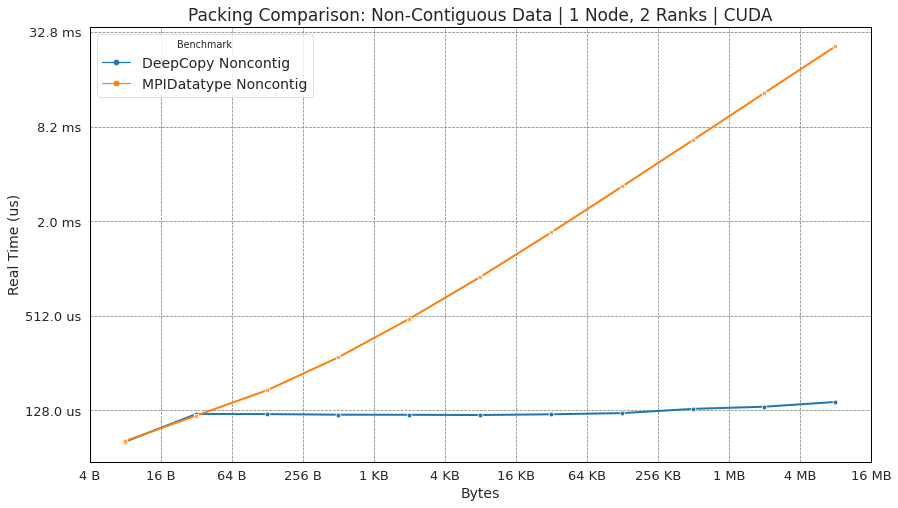

In [57]:
# Plot 9: Noncontig, 1 Node, GPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-Contiguous Data | 1 Node, 2 Ranks | CUDA', fontsize=fontsize + 4)
sbrn.lineplot(data=subset2, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.75)
plt.savefig("./3DSlice_Data/3dslicenoncontig_1nodeCUDA.png", dpi=300)
plt.show()

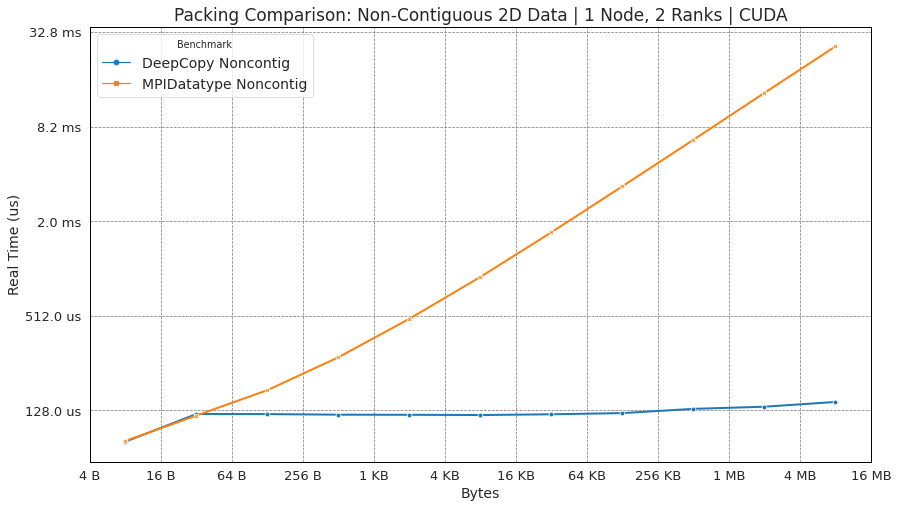

In [58]:
# Plot 10: Noncontig2D, 1 Node, GPU
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Non-Contiguous 2D Data | 1 Node, 2 Ranks | CUDA', fontsize=fontsize + 4)
sbrn.lineplot(data=subset2, x='bytes', y='real_time', hue='combined_type', 
              style='combined_type', markers=True, ci=None, linewidth=2, dashes=False)

plt.legend(title='Benchmark', fontsize=fontsize + 1)
plt.xlabel('Bytes', fontsize=fontsize + 1)
plt.ylabel('Real Time (us)', fontsize=fontsize + 1)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.75)
plt.savefig("./3DSlice_Data/3dslicenoncontig2D_1nodeCUDA.png", dpi=300)
plt.show()